# Regression: predict fuel efficiency

In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

import pathlib
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

### Load data

In [2]:
dataset_path = keras.utils.get_file("auto-mpg.data", "http://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data")
print(dataset_path)

C:\Users\user\.keras\datasets\auto-mpg.data


In [3]:
column_names = ['MPG','Cylinders','Displacement','Horsepower','Weight','Acceleration','Model Year','Origin']

raw_dataset = pd.read_csv(dataset_path, 
                          names=column_names,
                          na_values = "?", 
                          comment='\t', 
                          sep=" ", 
                          skipinitialspace=True)

dataset = raw_dataset.copy()
print(dataset.tail())

      MPG  Cylinders  Displacement  Horsepower  Weight  Acceleration  \
393  27.0          4         140.0        86.0  2790.0          15.6   
394  44.0          4          97.0        52.0  2130.0          24.6   
395  32.0          4         135.0        84.0  2295.0          11.6   
396  28.0          4         120.0        79.0  2625.0          18.6   
397  31.0          4         119.0        82.0  2720.0          19.4   

     Model Year  Origin  
393          82       1  
394          82       2  
395          82       1  
396          82       1  
397          82       1  


In [4]:
print(dataset.isna().sum())

dataset = dataset.dropna()

MPG             0
Cylinders       0
Displacement    0
Horsepower      6
Weight          0
Acceleration    0
Model Year      0
Origin          0
dtype: int64


In [5]:
# convert to a one-hot
origin = dataset.pop('Origin')
dataset['USA'] = (origin == 1)*1.0
dataset['Europe'] = (origin == 2)*1.0
dataset['Japan'] = (origin == 3)*1.0
print(dataset.tail())

      MPG  Cylinders  Displacement  Horsepower  Weight  Acceleration  \
393  27.0          4         140.0        86.0  2790.0          15.6   
394  44.0          4          97.0        52.0  2130.0          24.6   
395  32.0          4         135.0        84.0  2295.0          11.6   
396  28.0          4         120.0        79.0  2625.0          18.6   
397  31.0          4         119.0        82.0  2720.0          19.4   

     Model Year  USA  Europe  Japan  
393          82  1.0     0.0    0.0  
394          82  0.0     1.0    0.0  
395          82  1.0     0.0    0.0  
396          82  1.0     0.0    0.0  
397          82  1.0     0.0    0.0  


In [6]:
# Split train/test
train_dataset = dataset.sample(frac=0.8,random_state=0)
test_dataset = dataset.drop(train_dataset.index)

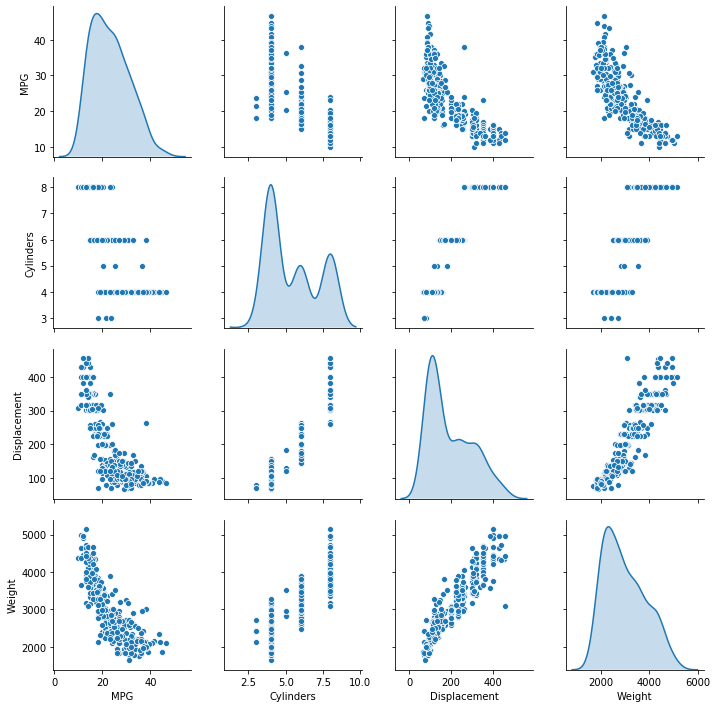

In [7]:
# Explore the data
sns.pairplot(train_dataset[["MPG", "Cylinders", "Displacement", "Weight"]], diag_kind="kde")
plt.show()

In [8]:
train_stats = train_dataset.describe()
train_stats.pop("MPG")
train_stats = train_stats.transpose()
print(train_stats)

              count         mean         std     min      25%     50%  \
Cylinders     314.0     5.477707    1.699788     3.0     4.00     4.0   
Displacement  314.0   195.318471  104.331589    68.0   105.50   151.0   
Horsepower    314.0   104.869427   38.096214    46.0    76.25    94.5   
Weight        314.0  2990.251592  843.898596  1649.0  2256.50  2822.5   
Acceleration  314.0    15.559236    2.789230     8.0    13.80    15.5   
Model Year    314.0    75.898089    3.675642    70.0    73.00    76.0   
USA           314.0     0.624204    0.485101     0.0     0.00     1.0   
Europe        314.0     0.178344    0.383413     0.0     0.00     0.0   
Japan         314.0     0.197452    0.398712     0.0     0.00     0.0   

                  75%     max  
Cylinders        8.00     8.0  
Displacement   265.75   455.0  
Horsepower     128.00   225.0  
Weight        3608.00  5140.0  
Acceleration    17.20    24.8  
Model Year      79.00    82.0  
USA              1.00     1.0  
Europe       

In [9]:
train_labels = train_dataset.pop('MPG')
test_labels = test_dataset.pop('MPG')

In [10]:
# Normalize the data
def norm(x):
    return (x - train_stats['mean']) / train_stats['std']

normed_train_data = norm(train_dataset)
normed_test_data = norm(test_dataset)

### Build the model

In [11]:
def build_model():
    model = keras.Sequential([
        layers.Dense(64, activation=tf.nn.relu, input_shape=[len(train_dataset.keys())]),
        layers.Dense(64, activation=tf.nn.relu),
        layers.Dense(1)
    ])

    optimizer = tf.keras.optimizers.RMSprop(0.001)

    model.compile(loss='mean_squared_error',
                  optimizer=optimizer,
                  metrics=['mean_absolute_error', 'mean_squared_error'])
    
    return model

model = build_model()

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [12]:
EPOCHS = 100
history1 = model.fit(normed_train_data, train_labels,
                     epochs=EPOCHS, 
                     validation_split = 0.2, 
                     verbose=0)

In [13]:
def print_history(history):
    hist = pd.DataFrame(history.history)
    hist['epoch'] = history.epoch
    print(hist.tail(10))

def plot_history(history):
    hist = pd.DataFrame(history.history)
    hist['epoch'] = history.epoch

    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Mean Abs Error [MPG]')
    plt.plot(hist['epoch'], hist['mean_absolute_error'], label='Train Error')
    plt.plot(hist['epoch'], hist['val_mean_absolute_error'], label = 'Val Error')
    plt.ylim([0,5])
    plt.legend()

    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.plot(hist['epoch'], hist['loss'], label='Train Loss')
    plt.plot(hist['epoch'], hist['val_loss'], label = 'Val Loss')
    plt.ylim([0,20])
    plt.legend()
    plt.show()

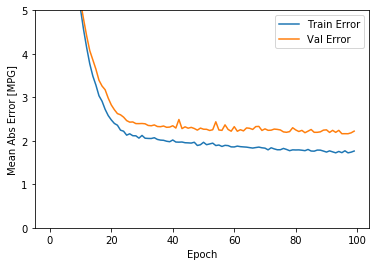

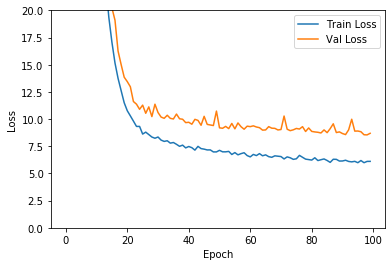

In [14]:
plot_history(history1)

###  EarlyStopping

In [15]:
model = build_model()

# The patience parameter is the amount of epochs to check for improvement
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=20, verbose=1)

EPOCHS = 1000
history2 = model.fit(normed_train_data, train_labels,
                     epochs=EPOCHS, 
                     validation_split=0.2, 
                     verbose=0,
                     callbacks=[early_stop])

Epoch 00174: early stopping


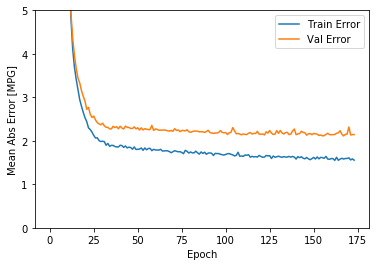

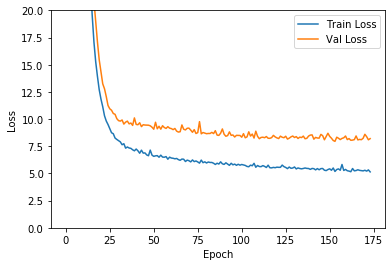

In [16]:
plot_history(history2)

### Make predictions

In [17]:
test_predictions = model.predict(normed_test_data).flatten()

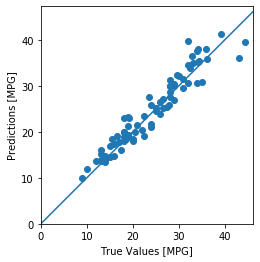

In [18]:
plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values [MPG]')
plt.ylabel('Predictions [MPG]')
plt.axis('equal')
plt.axis('square')
plt.xlim([0,plt.xlim()[1]])
plt.ylim([0,plt.ylim()[1]])
_ = plt.plot([-100, 100], [-100, 100])
plt.show()

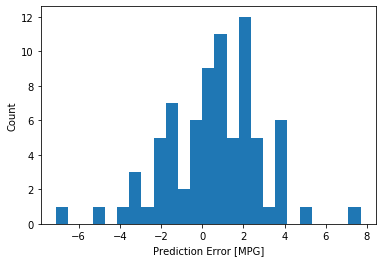

In [19]:
# error distribution
error = test_predictions - test_labels
plt.hist(error, bins = 25)
plt.xlabel("Prediction Error [MPG]")
_ = plt.ylabel("Count")
plt.show()